<a href="https://colab.research.google.com/github/BhaveshNikam09/Deep_learning_practise/blob/main/self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install roboflow
!pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:0

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="o0qlzMSdjo45PEreymoH")
project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [2]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances(
    "self-car",
    {},
    "/content/Self-Driving-Car-3/export/_annotations.coco.json",
    "/content/Self-Driving-Car-3/export"

)


In [3]:
from detectron2.data import MetadataCatalog,DatasetCatalog

dataset_dict=DatasetCatalog.get('self-car')
metadata=MetadataCatalog.get('self-car')

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



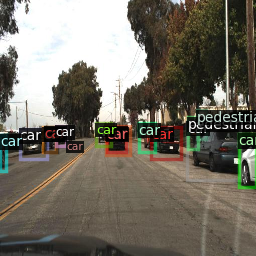

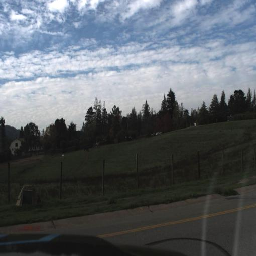

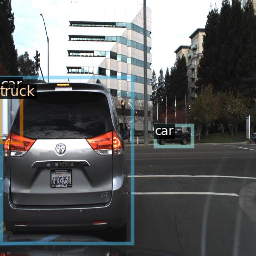

In [4]:
import random
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow
import cv2

for d in random.sample(dataset_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("self-car",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 7000  # 7000 iterations
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/13 17:56:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/13 17:56:20 d2.engine.train_loop]: Starting training from iteration 0
[04/13 17:56:26 d2.utils.events]:  eta: 0:34:14  iter: 19  total_loss: 3.593  loss_cls: 2.598  loss_box_reg: 0.8608  loss_rpn_cls: 0.06227  loss_rpn_loc: 0.05377    time: 0.2897  last_time: 0.2772  data_time: 0.0211  last_data_time: 0.0058   lr: 4.9953e-06  max_mem: 2218M
[04/13 17:56:31 d2.utils.events]:  eta: 0:33:22  iter: 39  total_loss: 3.429  loss_cls: 2.487  loss_box_reg: 0.8265  loss_rpn_cls: 0.05215  loss_rpn_loc: 0.0712    time: 0.2855  last_time: 0.2145  data_time: 0.0089  last_data_time: 0.0051   lr: 9.9903e-06  max_mem: 2221M
[04/13 17:56:37 d2.utils.events]:  eta: 0:33:27  iter: 59  total_loss: 3.27  loss_cls: 2.243  loss_box_reg: 0.8752  loss_rpn_cls: 0.0525  loss_rpn_loc: 0.07008    time: 0.2872  last_time: 0.2959  data_time: 0.0100  last_data_time: 0.0143   lr: 1.4985e-05  max_mem: 2221M
[04/13 17:56:43 d2.utils.events]:  eta: 0:32:58  iter: 79  total_loss: 2.806  loss_cls: 1.939  loss_box_reg: 0

In [7]:
from detectron2.data import DatasetCatalog
print("Sample dict:", DatasetCatalog.get("self-car")[0])

[04/13 18:32:56 d2.data.datasets.coco]: Loading /content/Self-Driving-Car-3/export/_annotations.coco.json takes 1.59 seconds.
WARNING [04/13 18:32:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/13 18:32:56 d2.data.datasets.coco]: Loaded 29800 images in COCO format from /content/Self-Driving-Car-3/export/_annotations.coco.json
Sample dict: {'file_name': '/content/Self-Driving-Car-3/export/1478897026627294725_jpg.rf.6828a4e821cbab4c2c277d74df291f00.jpg', 'height': 512, 'width': 512, 'image_id': 0, 'annotations': [{'iscrowd': 0, 'bbox': [140, 262, 21, 25.5], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [266, 231, 24, 95.5], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [271, 241, 17, 76], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [280, 220, 89.5, 121], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


In [23]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/13 18:56:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


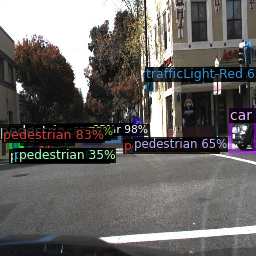

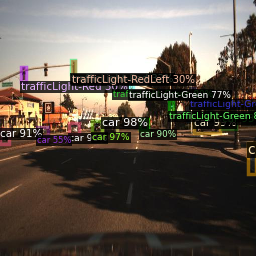

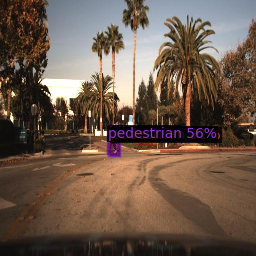

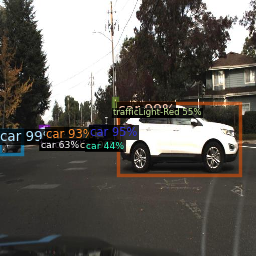

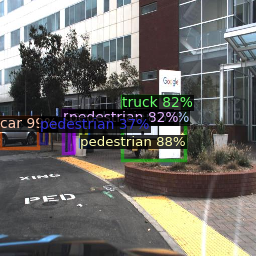

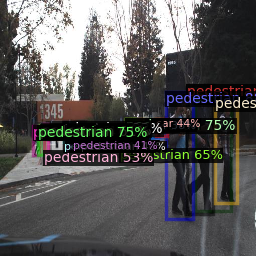

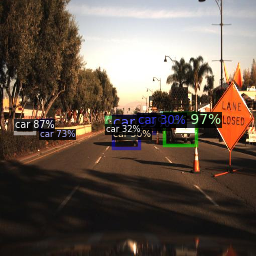

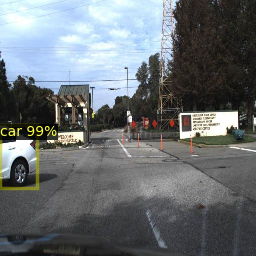

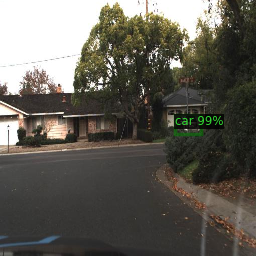

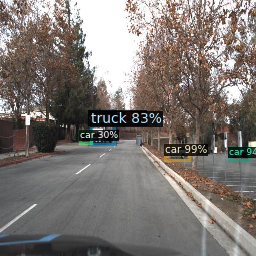

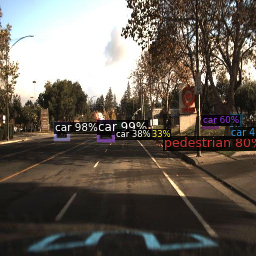

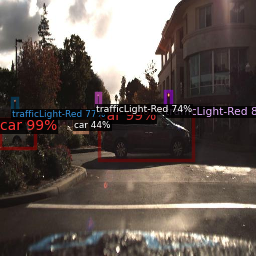

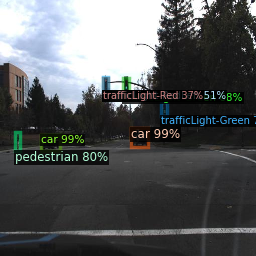

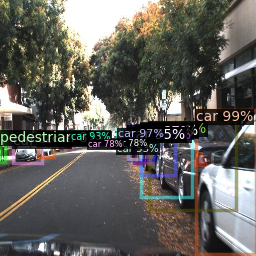

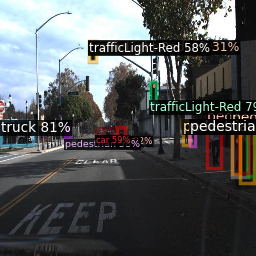

In [24]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = dataset_dict
for d in random.sample(dataset_dicts, 15):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=0.5,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

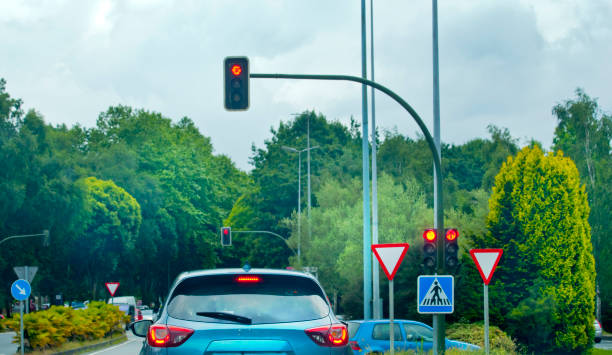

In [25]:
img=cv2.imread('/content/cR.jpg')
cv2_imshow(img)
outputs = predictor(img)

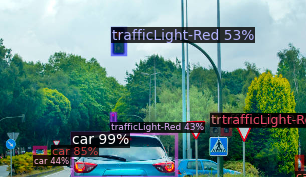

In [27]:
v = Visualizer(img[:, :, ::-1],
                   metadata=metadata,
                   scale=0.5,
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out1= v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out1.get_image()[:, :, ::-1])

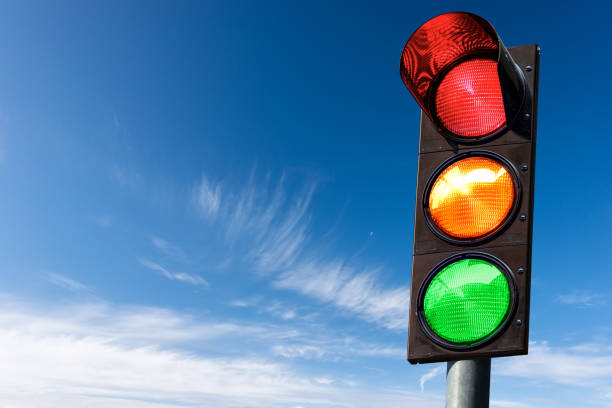

In [29]:
img=cv2.imread('/content/sign.jpg')
cv2_imshow(img)
outputs = predictor(img)

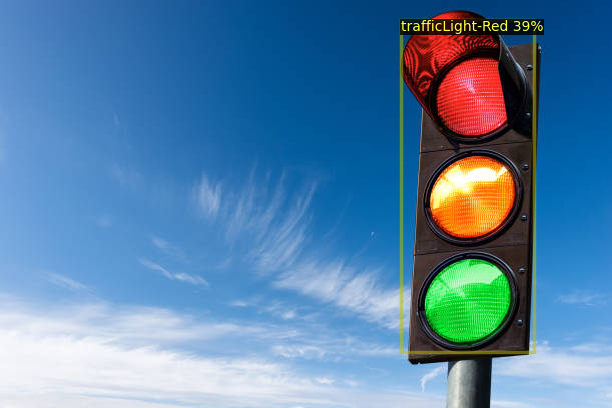

In [32]:
v=Visualizer(img[:, : ,::-1],
             metadata=metadata,
             )
out2= v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out2.get_image()[:, :, ::-1])